In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split, Subset

import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

import json

In [2]:
# seed = np.random.randint(1, 10000)
# print(f"{seed}")

seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device.type.upper()}")


Running on CUDA


In [3]:
class CustomDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32)

In [4]:
with open('/PATH_TO_FILE/data_parsed.json') as f:
    data = json.load(f)


# Extract the relevant values
vals = ["energy", "theta", "phi", "l", "b", "ra", "dec", "dEdXmax", "distXmax", "heightXmax", "xmax", "totalEnergy"]

# Find the minimum length to make sure all fields have the same size
min_length = min(
    len(data['sdrec']['energy']),
    len(data['sdrec']['theta']),
    len(data['sdrec']['phi']),
    len(data['sdrec']['l']),
    len(data['sdrec']['b']),
    len(data['sdrec']['ra']),
    len(data['sdrec']['dec']),
    len(data['fdrec']['dEdXmax']),
    len(data['fdrec']['distXmax']),
    len(data['fdrec']['heightXmax']),
    len(data['fdrec']['xmax']),
    len(data['fdrec']['totalEnergy'])
)

print(f"Minimum length of data: {min_length}")

# Organize data into a matrix
data_values = np.array([
    data['sdrec']['energy'][:min_length],
    data['sdrec']['theta'][:min_length],
    data['sdrec']['phi'][:min_length],
    data['sdrec']['l'][:min_length],
    data['sdrec']['b'][:min_length],
    data['sdrec']['ra'][:min_length],
    data['sdrec']['dec'][:min_length],
    data['fdrec']['dEdXmax'][:min_length],
    data['fdrec']['distXmax'][:min_length],
    data['fdrec']['heightXmax'][:min_length],
    data['fdrec']['xmax'][:min_length],
    data['fdrec']['totalEnergy'][:min_length]
]).T

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_values)

data_tensor = torch.tensor(data_scaled, dtype=torch.float)
dataset = CustomDataset(data_scaled)

torch.manual_seed(seed)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_data_scaled = torch.utils.data.Subset(data_scaled, train_dataset.indices)
val_data_scaled = torch.utils.data.Subset(data_scaled, val_dataset.indices)
test_data_scaled = torch.utils.data.Subset(data_scaled, test_dataset.indices)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# PAZI data_scaled je Pytorch subset potrebujemo tensor
tds_tensor = torch.stack([torch.tensor(x) for x in test_data_scaled])  # vsak mora biti tensor

# pytorch -> numpy tenzor
tds_tensor = tds_tensor.numpy()

Minimum length of data: 1565


In [5]:
base_dist = dist.Normal(torch.zeros(data_tensor.shape[1]), torch.ones(data_tensor.shape[1]))
spline_transform = T.spline_coupling(data_tensor.shape[1], count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [6]:
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)

train_loss_list = []
val_loss_list = []

epochs = 36  # Number of epochs to train
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0

    # Training step
    flow_dist.clear_cache()  # Clear cache between epochs
    spline_transform.train()  # Set model to training mode
    for batch in train_loader:
        optimizer.zero_grad()
        loss = -flow_dist.log_prob(batch).mean()  # Negative log likelihood
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(batch)
    
    # Validation step
    spline_transform.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for batch in val_loader:
            loss = -flow_dist.log_prob(batch).mean()
            val_loss += loss.item() * len(batch)

    # Compute average losses
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')




Epoch: 0, Train Loss: 25.075251986011523, Val Loss: 22.293116104908478
Epoch: 5, Train Loss: 16.377983214321745, Val Loss: 15.449978290460049
Epoch: 10, Train Loss: 13.444046742513299, Val Loss: 13.063336176749987
Epoch: 15, Train Loss: 12.1880326353796, Val Loss: 11.68402128138094
Epoch: 20, Train Loss: 11.425287717009244, Val Loss: 11.346870520176031
Epoch: 25, Train Loss: 10.940093314810975, Val Loss: 11.247937789330116
Epoch: 30, Train Loss: 10.778872504735102, Val Loss: 10.936929148486536
Epoch: 35, Train Loss: 10.226123007682904, Val Loss: 11.00328296270126


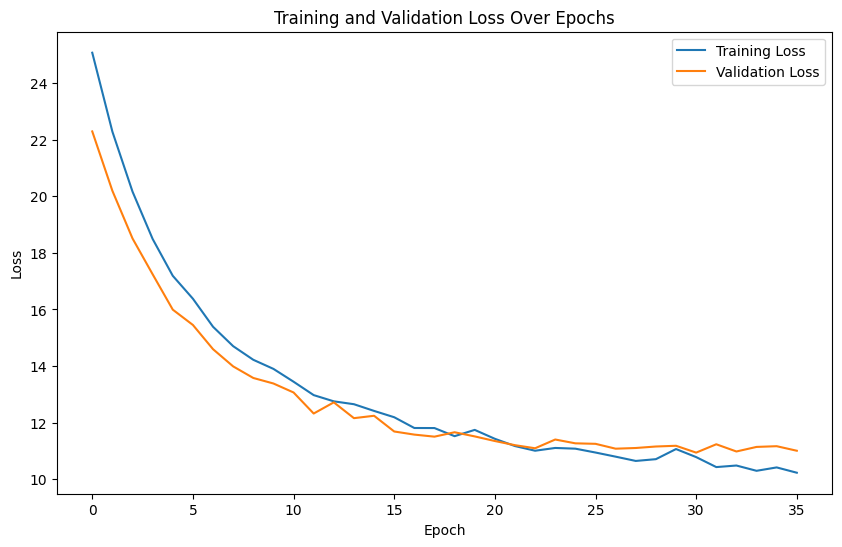

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [8]:
def compute_data_overlap(original_samples, generated_samples, bandwidth='scott'):
    """
    Computes the probability of overlap between original and generated samples.

    Parameters:
    - original_samples (torch.Tensor): Tensor of original data samples.
    - generated_samples (torch.Tensor): Tensor of generated data samples.
    - bandwidth (str or float): The bandwidth of the kernel. 'scott' or 'silverman' can be used for automatic selection, or specify a float value.

    Returns:
    - overlap_probability (float): The computed probability of overlap between the original and generated samples.
    """
    # Convert samples to numpy for KDE
    original_samples_np = original_samples.T
    generated_samples_np = generated_samples.T

    # Ensure both arrays have the same number of samples by sampling the smaller set
    min_samples = min(original_samples_np.shape[1], generated_samples_np.shape[1])
    original_samples_np = original_samples_np[:, np.random.choice(original_samples_np.shape[1], min_samples, replace=False)]
    generated_samples_np = generated_samples_np[:, np.random.choice(generated_samples_np.shape[1], min_samples, replace=False)]

    # Create KDEs for both distributions
    kde_original = gaussian_kde(original_samples_np, bw_method=bandwidth)
    kde_generated = gaussian_kde(generated_samples_np, bw_method=bandwidth)

    # Evaluate the KDEs over the same grid
    sample_points = np.hstack([original_samples_np, generated_samples_np])

    original_density = kde_original(sample_points)
    generated_density = kde_generated(sample_points)

    # Compute overlap as the minimum density at each point
    overlap_density = np.minimum(original_density, generated_density)

    # Integrate the overlap density to get the total overlap probability
    overlap_probability = np.sum(overlap_density) / np.sum(kde_original(sample_points))

    return overlap_probability

In [9]:
def plot_histogram_overlap(original_data, generated_data, vals, bins=18):
    """
    Plot overlapping histograms of original and generated data with sqrt(n) error bars for the original data.
    
    Parameters:
    - original_data (np.array): Original data from the dataset.
    - generated_data (np.array): Data generated by the model.
    - vals (list of str): List of labels for each feature.
    - bins (int): Number of bins to use for histograms.
    """

    vals = ["energy", "theta", "phi", "l", "b", "ra", "dec", "dEdXmax", "distXmax", "heightXmax", "xmax", "totalEnergy"]

    num_features = 12 #original_data.shape[1]
    fig, axs = plt.subplots(1, num_features, figsize=(5 * num_features, 5), constrained_layout=True)
    
    if num_features == 1:
        axs = [axs]
    
    for i in range(num_features):
        # Originalni + 
        counts, bin_edges = np.histogram(original_data[:, i], bins=bins, density=True, range=(np.min(generated_data[:,i]), np.max(generated_data[:,i])))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        errors = np.sqrt(counts / len(original_data))  # sqrt(n) error bars
        axs[i].errorbar(bin_centers, counts, yerr=errors, fmt='o', label='Original (with errors)', color='blue')

        # Histogrami za generirane
        axs[i].hist(generated_data[:, i], bins=bins, density=True, alpha=0.6, label='Generated', color='orange')
        
        axs[i].set_title(f'{vals[i]}')
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Density')
        axs[i].legend()

    plt.suptitle('Original vs Generated Data Overlap')
    plt.savefig(f"overlap_histograms.png")
    plt.show()

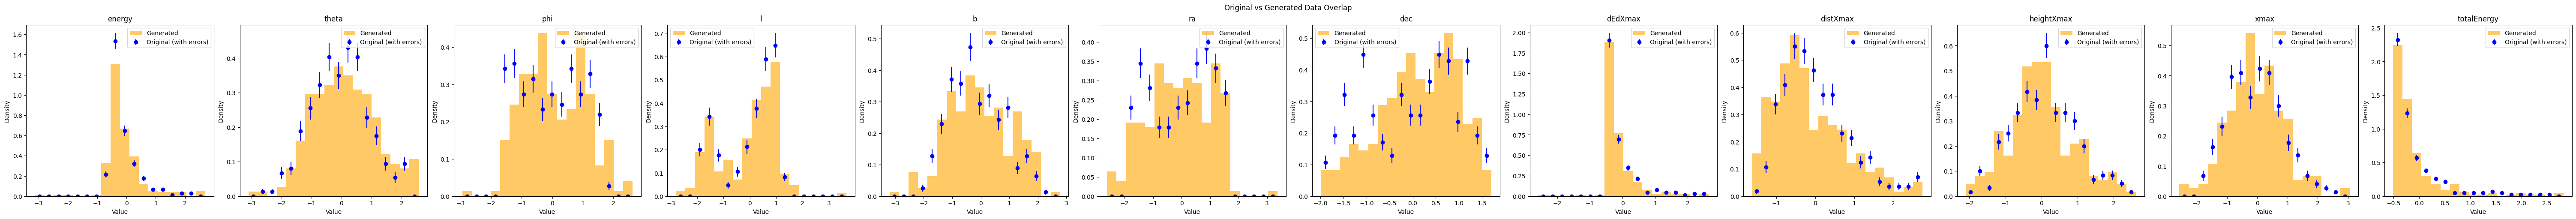

Final probability of 12D data overlap: 0.0083


In [10]:
generated_samples = flow_dist.sample(torch.Size([test_size])).detach().numpy()

plot_histogram_overlap(tds_tensor, generated_samples, vals)

overlap_probability_12d = compute_data_overlap(tds_tensor, generated_samples)
print(f"Final probability of 12D data overlap: {overlap_probability_12d:.4f}")